# Res Net - Repurposing/Finetuning
## Introduction

This notebook is an attempt to repurpose and finetune an ResNet model to the task of American Sign Language detection for the DSPRO2 project at HSLU.

## Setup
In this section all the necessary libraries are imported.

In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch.nn as nn
import torchvision.models as visionmodels

import os

# Our own modules
import models.sweep_helper as sweep_helper


from models.asl_model import ASLModel
from models.training import sweep, train_model

In [ ]:
from datapipeline.asl_image_data_module import ASLImageDataModule
from datapipeline.asl_kaggle_image_data_module import ASLKaggleImageDataModule, DEFAULT_TRANSFORMS

In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./dspro2/efficientnet.ipynb"

## Preprocessing
No general data preprocessing is necessary, however there will be random transforms applied to the images during training. The images are resized to 224x224 pixels, which is the input size of the EfficientNet model. The images are also normalized using the mean and standard deviation of the ImageNet dataset, which is the dataset on which the EfficientNet model was pretrained.

The following cells will show the loading of the dataset and the preparation of the mentioned transforms.

In [5]:
PATH = "/exchange/dspro2/silent-speech/ASL_Pictures_Dataset"
PATH = r"C:\Temp\silent-speech"

In [4]:
# datamodule = ASLImageDataModule(path=PATH, val_split_folder="Validation", batch_size=32, num_workers=128)
datamodule = ASLKaggleImageDataModule(path=PATH, train_transforms=DEFAULT_TRANSFORMS.TRAIN, valid_transforms=DEFAULT_TRANSFORMS.VALID, test_transforms=DEFAULT_TRANSFORMS.TEST, batch_size=32, num_workers=20)

## Models

In [6]:
NUM_CLASSES = 28

In [7]:
class ASLResNet34(nn.Module):
    def __init__(self, resnet_model: visionmodels.resnet.ResNet, dropout: float = 0.2, unfreeze_layers: int = 0, num_classes: int = NUM_CLASSES):
        super().__init__()

        self.resnet_num_layers = 4
        self.model = resnet_model
        self.model.requires_grad_(False)

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

        unfreeze_layers = min(unfreeze_layers, self.resnet_num_layers)

        for layer_num in range(self.resnet_num_layers, self.resnet_num_layers - unfreeze_layers, -1):
            self.model.get_submodule(f"layer{layer_num}").requires_grad_(True)

    def forward(self, x):
        return self.model(x)

    def get_main_params(self):
        yield from self.model.fc.parameters()

    def get_finetune_params(self):
        for name, param in self.model.named_parameters():
            if not name.startswith("fc") and param.requires_grad:
                yield param

## Training

In [8]:
DROPOUT = "dropout"

In [9]:
def get_pretrained_resnet_model():
    resnet_model = visionmodels.resnet34(weights=visionmodels.ResNet34_Weights.DEFAULT)
    return resnet_model

In [10]:
UNFREEZE_LAYERS = "unfreeze_layers"


def get_asl_resnet_model(resnet_model: visionmodels.resnet.ResNet, dropout: float, unfreeze_layers: int = 0) -> nn.Module:
    model = ASLResNet34(resnet_model, dropout=dropout, unfreeze_layers=unfreeze_layers)
    return model

In [11]:
def get_resnet_model_from_config(config: dict) -> nn.Module:
    resnet_model = get_pretrained_resnet_model()
    model = get_asl_resnet_model(resnet_model, config[DROPOUT], config[UNFREEZE_LAYERS])
    return model

In [12]:
run_id = 0
SEED = 42


def train_resnet():
    train_model("resnet", get_resnet_model_from_config, datamodule, get_optimizer=sweep_helper.get_optimizer_with_finetune_group, seed=SEED)

In [13]:
sweep_config = {
    "name": "ResNet34",
    "method": "bayes",
    "metric": {
        "name": f"{ASLModel.VALID_ACCURACY}",
        "goal": "maximize"
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    },
    "parameters": {
        UNFREEZE_LAYERS: {
            "value": 1
        },
        DROPOUT: {
            "min": 0.1,
            "max": 0.5
        },
        sweep_helper.OPTIMIZER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "value": sweep_helper.OptimizerType.RMSPROP
                },
                sweep_helper.LEARNING_RATE: {
                    "min": 1e-5,
                    "max": 1e-3,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.FINETUNE_LEARNING_RATE: {
                    "min": 1e-7,
                    "max": 1e-5,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.WEIGHT_DECAY: {
                    "min": 0,
                    "max": 1e-3,
                },
                sweep_helper.MOMENTUM: {
                    "min": 0.8,
                    "max": 0.99
                }
            }
        },
        sweep_helper.LEARNING_RATE_SCHEDULER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "values": [sweep_helper.LearningRateSchedulerType.STEP, sweep_helper.LearningRateSchedulerType.EXPONENTIAL]
                },
                sweep_helper.STEP_SIZE: {"value": 5},
                sweep_helper.GAMMA: {
                    "min": 0.1,
                    "max": 0.9
                }
            }
        }
    }
}

In [16]:
sweep(sweep_config=sweep_config, count=30, training_procedure=train_resnet)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 936doymo
Sweep URL: https://wandb.ai/dspro2-silent-speech/silent-speech/sweeps/936doymo


wandb: Agent Starting Run: hh8kuici with config:
wandb: 	dropout: 0.2988697278905561
wandb: 	learning_rate_scheduler: {'gamma': 0.16548742023922475, 'step_size': 5, 'type': 'step'}
wandb: 	optimizer: {'finetune_learning_rate': 5.791687333197608e-06, 'learning_rate': 4.671117090322782e-05, 'momentum': 0.8479938708012824, 'type': 'rmsprop', 'weight_decay': 0.0008869032076292996}
wandb: 	unfreeze_layers: 1
Seed set to 42
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.
wandb: Currently logged in as: v8-luky (dspro2-silent-speech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Split folders already exist, skipping distribution.


c:\Users\kybur\Repos\HSLU\dspro2\.venv\Lib\site-packages\lightning\pytorch\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ASLResNet34        | 21.3 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
13.1 M    Trainable params
8.2 M     Non-trainable params
21.3 M    Total params
85.196    Total estimated model params size (MB)
123       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kybur\Repos\HSLU\dspro2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


# Evaluation

In [14]:
from datapipeline.asl_image_test_data_module import ASLImageTestDataModule
from models.evaluation import Evaluation, show_confusion_matrix
from models.training import PROJECT_NAME, ENTITY_NAME

In [15]:
TEST_FOLDER =r"C:\Users\kybur\OneDrive - Hochschule Luzern\Projects\DSPRO2\Images\Cropped"

In [16]:
test_datamodule = ASLImageTestDataModule(path=TEST_FOLDER, num_workers=1)

In [17]:
# Prepare the model here (will load the state-dict of the W&B artifact into this architecture when evaluating)
architecture = get_asl_resnet_model(get_pretrained_resnet_model(), 0, 1)

The W&B artifact to load for example [such an articat](https://wandb.ai/dspro2-silent-speech/silent-speech/artifacts/model/model-tkdfqewx/v0) that is linked to a run.

In [18]:
artifact = "model-ug1q19n4:v0"

In [19]:
evaluation = Evaluation("resnet-34-finetune-eval", project=PROJECT_NAME, entity=ENTITY_NAME, model_architecture=architecture, artifact=artifact, datamodule=test_datamodule)

In [20]:
results = evaluation()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/efficientnet.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: v8-luky (v8-luky-university-of-applied-sciences-lucerne) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-ug1q19n4:v0, 181.57MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:8.2
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\kybur\Repos\HSLU\dspro2\.venv\Lib\site-packages\lightning\pytorch\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before insta

Testing DataLoader 0: 100%|██████████| 22/22 [00:07<00:00,  2.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3516642451286316
        test_loss            5.206417083740234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kybur\Repos\HSLU\dspro2\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]


epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.35166
test_loss,5.20642
trainer/global_step,0


In [21]:
predictions, targets = results

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix ResNet34'}, xlabel='Predicted label', ylabel='True label'>)

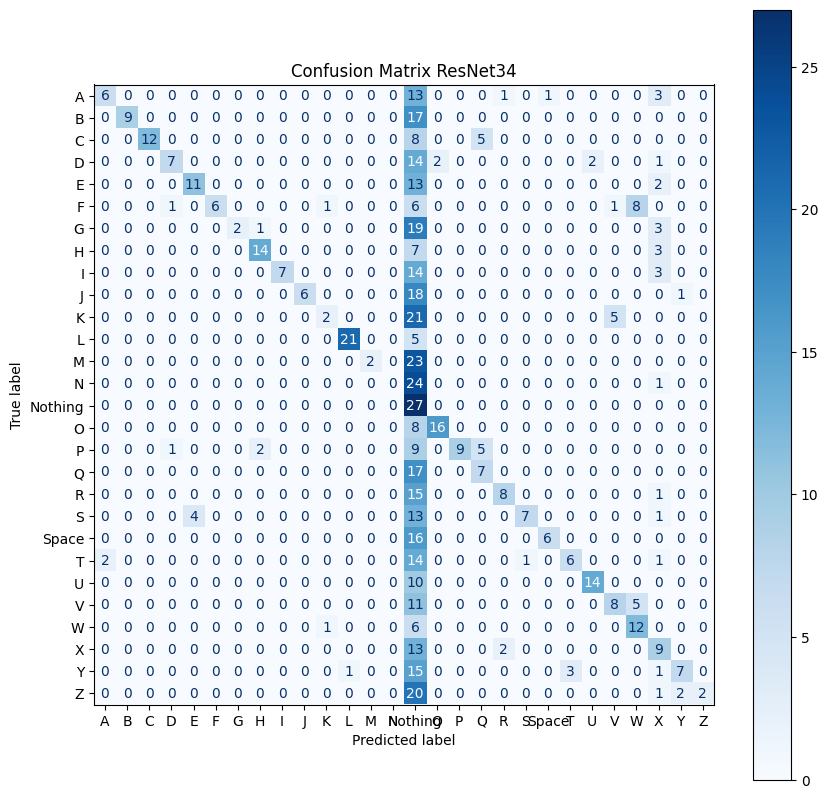

In [24]:
show_confusion_matrix(targets, predictions, title="Confusion Matrix ResNet34")